# Introduction

The goal of this competition is to predict the total number of bikes rented during each hour of the last days of each month in the dataset.

The evaluation is based on the Root Mean Squared Logarithmic Error.

I will use a simple linear regression to catch trend and seasonality and I will try to improve the score running a XGB regressor on the residuals.

# Loading libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
import warnings

In [3]:
from scipy.stats import skew, norm, zscore

In [4]:
from statsmodels.api import OLS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV, RepeatedKFold, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer, mean_squared_log_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

In [6]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

In [7]:
warnings.filterwarnings('ignore')

In [8]:
sns.set_theme()

In [9]:
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bike-sharing-demand/sampleSubmission.csv
/kaggle/input/bike-sharing-demand/train.csv
/kaggle/input/bike-sharing-demand/test.csv


# Importing the dataset

In [10]:
train = pd.read_csv("/kaggle/input/bike-sharing-demand/train.csv", parse_dates=['datetime'])

In [11]:
test = pd.read_csv("/kaggle/input/bike-sharing-demand/test.csv", parse_dates=['datetime'])

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [13]:
train.sample(10)

datetime  season  holiday  workingday  weather   temp   atemp  \
4339 2011-10-12 20:00:00       4        0           1        3  22.14  25.760   
5279 2011-12-14 01:00:00       4        0           1        1  10.66  15.150   
8046 2012-06-15 15:00:00       2        0           1        1  29.52  32.575   
7879 2012-06-08 16:00:00       2        0           1        1  31.16  33.335   
691  2011-02-12 03:00:00       1        0           0        1   4.92   9.850   
5211 2011-12-11 05:00:00       4        0           0        1   7.38  10.605   
9570 2012-10-03 03:00:00       4        0           1        2  24.60  25.760   
7322 2012-05-04 11:00:00       2        0           1        2  28.70  32.575   
4198 2011-10-06 23:00:00       4        0           1        1  18.04  21.970   
7992 2012-06-13 09:00:00       2        0           1        2  26.24  30.305   

      humidity  windspeed  casual  registered  count  
4339        94     7.0015       9          81     90  
5279        75     0.0000       0           8      8  
8046        39    12.9980     107         270    377  
7879        29    19.9995     111         412    523  
691         80     0.0000       3           7     10  
5211        59     7.0015       0           6      6  
9570        94     0.0000       0           7      7  
7322        61     0.0000      77         181    258  
4198        88     6.0032      18          81     99  
7992        69    39.0007      54         298    352

In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    6493 non-null   datetime64[ns]
 1   season      6493 non-null   int64         
 2   holiday     6493 non-null   int64         
 3   workingday  6493 non-null   int64         
 4   weather     6493 non-null   int64         
 5   temp        6493 non-null   float64       
 6   atemp       6493 non-null   float64       
 7   humidity    6493 non-null   int64         
 8   windspeed   6493 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 456.7 KB


In [15]:
test.sample(10)

datetime  season  holiday  workingday  weather   temp   atemp  \
5241 2012-08-24 05:00:00       3        0           1        1  26.24  29.545   
1641 2011-07-23 09:00:00       3        0           0        1  34.44  39.395   
6275 2012-12-22 20:00:00       1        0           0        1   9.84  12.120   
1562 2011-07-20 02:00:00       3        0           1        1  28.70  33.335   
459  2011-02-28 23:00:00       1        0           1        2  13.12  14.395   
789  2011-04-21 21:00:00       2        0           1        1  17.22  21.210   
6129 2012-11-27 17:00:00       4        0           1        2  12.30  13.635   
6135 2012-11-27 23:00:00       4        0           1        2  10.66  12.120   
741  2011-03-31 21:00:00       2        0           1        2  11.48  13.635   
2909 2011-11-29 19:00:00       4        0           1        2  16.40  20.455   

      humidity  windspeed  
5241        78     0.0000  
1641        49    11.0014  
6275        48    11.0014  
1562        84     0.0000  
459         81    26.0027  
789         47    12.9980  
6129        75    26.0027  
6135        81    16.9979  
741         93    11.0014  
2909        82    22.0028

In [16]:
conc_df = pd.concat([train,test])

In [17]:
conc_df = conc_df.set_index('datetime').sort_index()

In [18]:
conc_df.sample(10)

season  holiday  workingday  weather   temp   atemp  \
datetime                                                                   
2012-01-12 19:00:00       1        0           1        2  17.22  21.210   
2012-03-31 11:00:00       2        0           0        1  18.86  22.725   
2012-12-30 12:00:00       1        0           0        1  11.48  11.365   
2011-01-22 04:00:00       1        0           0        2   0.82   0.760   
2011-03-03 05:00:00       1        0           1        1   5.74   6.060   
2012-10-27 13:00:00       4        0           0        1  24.60  31.060   
2011-05-13 19:00:00       2        0           1        2  21.32  25.000   
2012-04-01 04:00:00       2        0           0        2  13.94  17.425   
2012-07-17 04:00:00       3        0           1        1  29.52  34.090   
2011-06-26 16:00:00       3        0           0        1  30.34  33.335   

                     humidity  windspeed  casual  registered  count  
datetime                                                             
2012-01-12 19:00:00        71    11.0014    17.0       313.0  330.0  
2012-03-31 11:00:00        72     8.9981     NaN         NaN    NaN  
2012-12-30 12:00:00        36    39.0007     NaN         NaN    NaN  
2011-01-22 04:00:00        48    19.9995     NaN         NaN    NaN  
2011-03-03 05:00:00        33    19.9995     1.0         7.0    8.0  
2012-10-27 13:00:00        43    16.9979     NaN         NaN    NaN  
2011-05-13 19:00:00        83    12.9980    25.0       245.0  270.0  
2012-04-01 04:00:00        81     6.0032     3.0         9.0   12.0  
2012-07-17 04:00:00        62     0.0000     0.0         7.0    7.0  
2011-06-26 16:00:00        42    12.9980     NaN         NaN    NaN

# Creating main time features

In [19]:
def time_feature_func (orig_df):
    
    df = orig_df.copy()
    
    df['year'] = df.index.year.astype('int')
    df['quarter'] = df.index.quarter.astype('int')
    df['month'] = df.index.month.astype('int')
    df['day'] = df.index.day.astype('int')
    df['hour'] = df.index.hour.astype('int')
    df['dayofweek'] = df.index.day_of_week.astype('int')
    df['weekofyear'] = df.index.week.astype('int')
    df['schoolholiday'] = df.month.apply(lambda x: 1 if x in (6,7,8) else 0)
    df['issunday'] = df.dayofweek.apply(lambda x: 1 if x == 6 else 0)
    
    return df

In [20]:
df = time_feature_func(conc_df)

In [21]:
df.sample(10)

season  holiday  workingday  weather   temp   atemp  \
datetime                                                                   
2011-03-13 14:00:00       1        0           0        1  18.86  22.725   
2011-08-06 11:00:00       3        0           0        1  31.98  37.120   
2012-01-18 22:00:00       1        0           1        1   7.38   8.335   
2012-11-06 20:00:00       4        0           1        1  12.30  14.395   
2011-12-25 19:00:00       1        0           0        1  13.12  16.665   
2011-07-09 11:00:00       3        0           0        1  31.98  34.850   
2012-07-09 16:00:00       3        0           1        1  31.98  34.850   
2012-01-17 02:00:00       1        0           1        3  11.48  13.635   
2012-02-14 11:00:00       1        0           1        2  12.30  15.150   
2012-10-06 03:00:00       4        0           0        1  22.14  25.760   

                     humidity  windspeed  casual  registered  count  year  \
datetime                                                                    
2011-03-13 14:00:00        41    19.9995   144.0       106.0  250.0  2011   
2011-08-06 11:00:00        62    15.0013   138.0       211.0  349.0  2011   
2012-01-18 22:00:00        47    16.9979     4.0        74.0   78.0  2012   
2012-11-06 20:00:00        61    15.0013    10.0       218.0  228.0  2012   
2011-12-25 19:00:00        57     8.9981     NaN         NaN    NaN  2011   
2011-07-09 11:00:00        46    19.9995   101.0       189.0  290.0  2011   
2012-07-09 16:00:00        40    19.0012    88.0       325.0  413.0  2012   
2012-01-17 02:00:00        75    16.9979     0.0        12.0   12.0  2012   
2012-02-14 11:00:00        45    11.0014     5.0       107.0  112.0  2012   
2012-10-06 03:00:00        77    15.0013     2.0        54.0   56.0  2012   

                     quarter  month  day  hour  dayofweek  weekofyear  \
datetime                                                                
2011-03-13 14:00:00        1      3   13    14          6          10   
2011-08-06 11:00:00        3      8    6    11          5          31   
2012-01-18 22:00:00        1      1   18    22          2           3   
2012-11-06 20:00:00        4     11    6    20          1          45   
2011-12-25 19:00:00        4     12   25    19          6          51   
2011-07-09 11:00:00        3      7    9    11          5          27   
2012-07-09 16:00:00        3      7    9    16          0          28   
2012-01-17 02:00:00        1      1   17     2          1           3   
2012-02-14 11:00:00        1      2   14    11          1           7   
2012-10-06 03:00:00        4     10    6     3          5          40   

                     schoolholiday  issunday  
datetime                                      
2011-03-13 14:00:00              0         1  
2011-08-06 11:00:00              1         0  
2012-01-18 22:00:00              0         0  
2012-11-06 20:00:00              0         0  
2011-12-25 19:00:00              0         1  
2011-07-09 11:00:00              1         0  
2012-07-09 16:00:00              1         0  
2012-01-17 02:00:00              0         0  
2012-02-14 11:00:00              0         0  
2012-10-06 03:00:00              0         0

# Plotting data

<AxesSubplot:xlabel='datetime'>

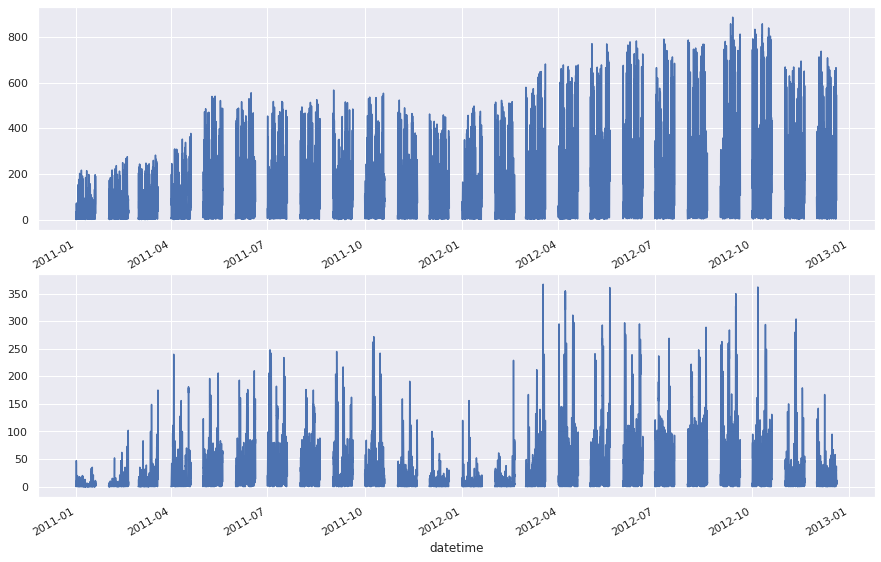

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(15,10))

df.registered.plot(ax=axes[0])
df.casual.plot(ax=axes[1])

<AxesSubplot:xlabel='season', ylabel='casual'>

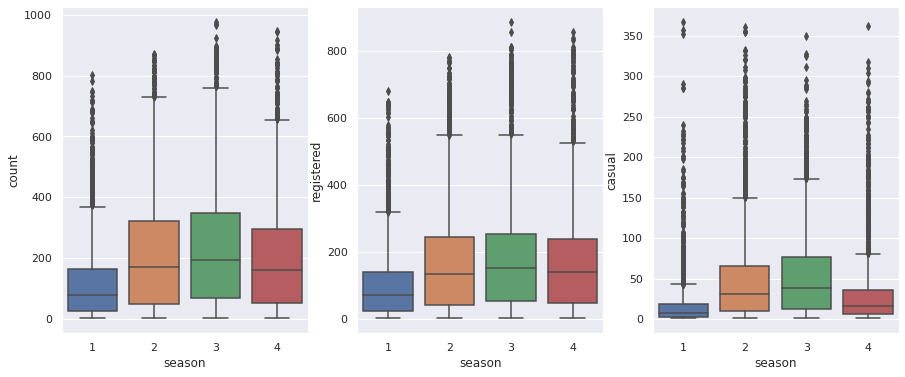

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(15,6))

sns.boxplot(y=df.query("count>0")['count'], x=df.season, ax=axes[0])
sns.boxplot(y=df.query("registered>0")['registered'], x=df.season, ax=axes[1])
sns.boxplot(y=df.query("casual>0")['casual'], x=df.season, ax=axes[2])

Text(0, 0.5, 'Count')

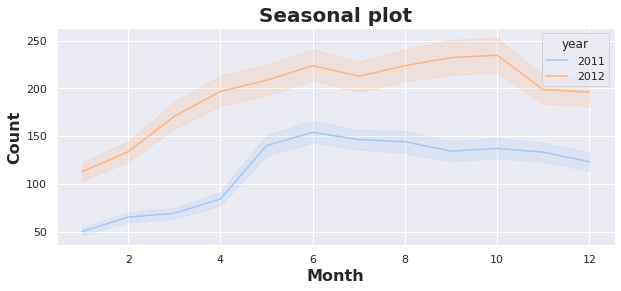

In [24]:
fig, ax = plt.subplots(figsize=(10, 4))

palette = sns.color_palette("pastel", 2)
sns.lineplot(df['month'], df['registered'], hue=df['year'], palette=palette)
ax.set_title('Seasonal plot', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Count', fontsize = 16, fontdict=dict(weight='bold'))

Text(0, 0.5, 'Count')

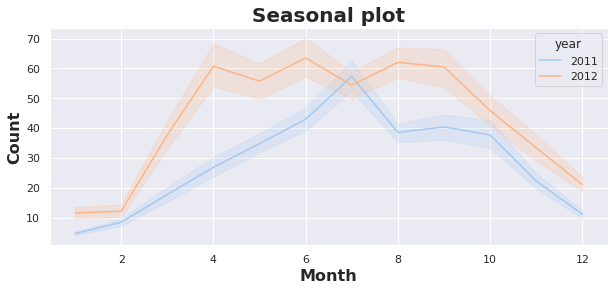

In [25]:
fig, ax = plt.subplots(figsize=(10, 4))

palette = sns.color_palette("pastel", 2)
sns.lineplot(df['month'], df['casual'], hue=df['year'], palette=palette)
ax.set_title('Seasonal plot', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Count', fontsize = 16, fontdict=dict(weight='bold'))

Text(0, 0.5, 'Count')

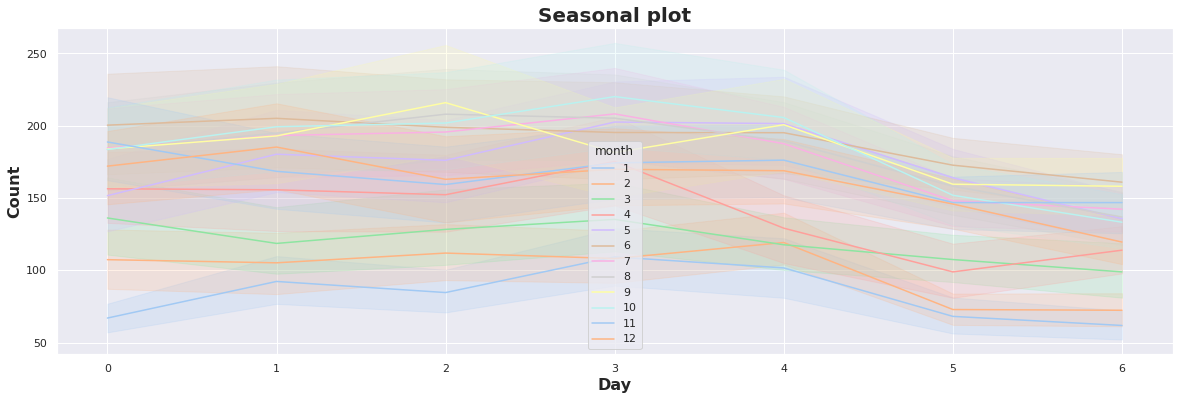

In [26]:
fig, ax = plt.subplots(figsize=(20, 6))

palette = sns.color_palette("pastel", 12)
sns.lineplot(df['dayofweek'], df['registered'], hue=df['month'], palette=palette)
ax.set_title('Seasonal plot', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Day', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Count', fontsize = 16, fontdict=dict(weight='bold'))

In [27]:
fig, ax = plt.subplots(figsize=(20, 6))

palette = sns.color_palette("pastel", 12)
sns.lineplot(df['dayofweek'], df['casual'], hue=df['month'], palette=palette)
ax.set_title('Seasonal plot', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Day', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Count', fontsize = 16, fontdict=dict(weight='bold'))

Text(0, 0.5, 'Count')

Text(0, 0.5, 'Count')

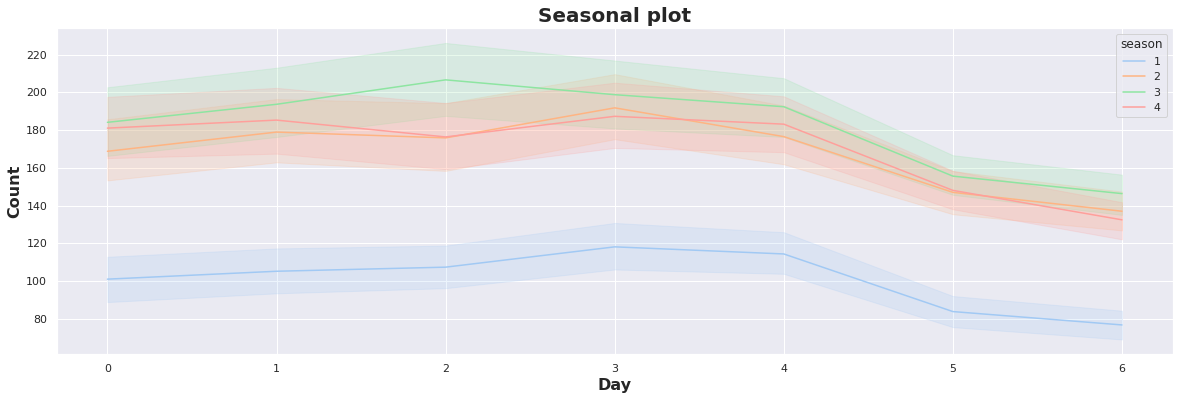

In [28]:
fig, ax = plt.subplots(figsize=(20, 6))

palette = sns.color_palette("pastel", 4)
sns.lineplot(df['dayofweek'], df['registered'], hue=df['season'], palette=palette)
ax.set_title('Seasonal plot', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Day', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Count', fontsize = 16, fontdict=dict(weight='bold'))

Text(0, 0.5, 'Count')

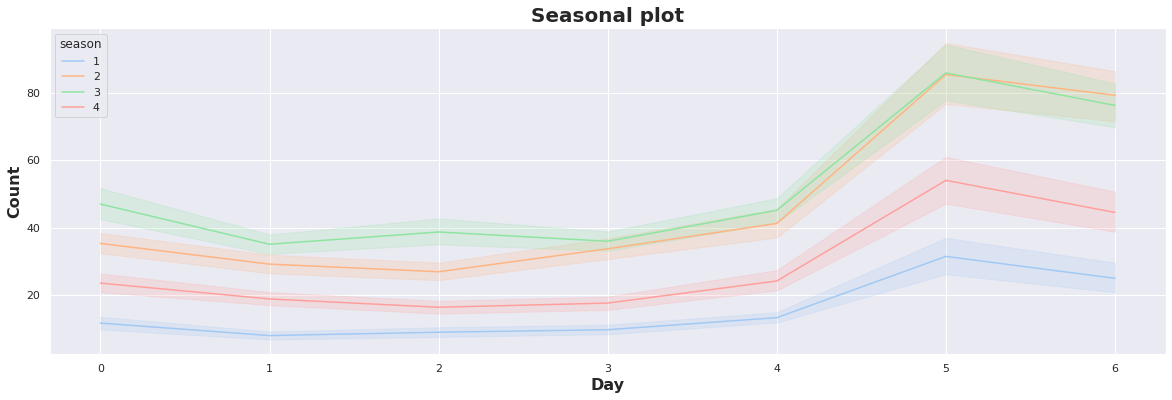

In [29]:
fig, ax = plt.subplots(figsize=(20, 6))

palette = sns.color_palette("pastel", 4)
sns.lineplot(df['dayofweek'], df['casual'], hue=df['season'], palette=palette)
ax.set_title('Seasonal plot', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Day', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Count', fontsize = 16, fontdict=dict(weight='bold'))

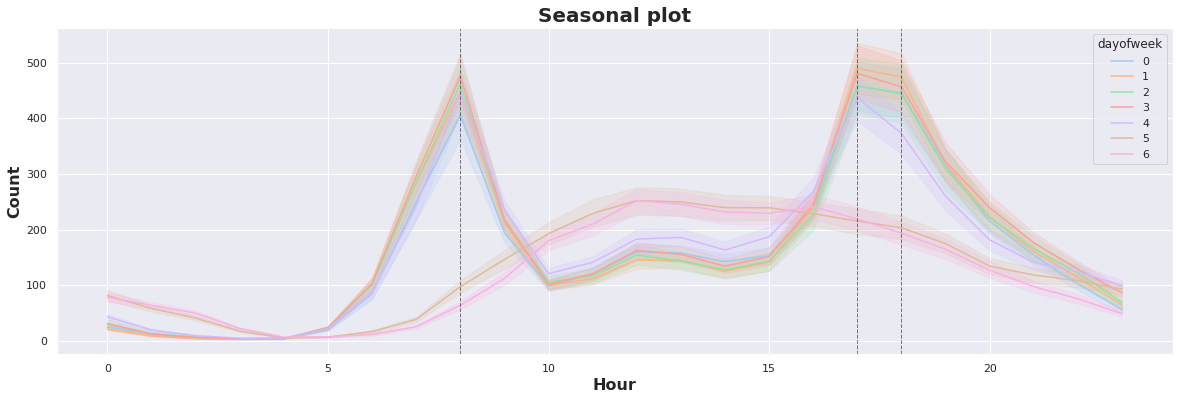

In [30]:
fig, ax = plt.subplots(figsize=(20, 6))

palette = sns.color_palette("pastel", 7)
sns.lineplot(df['hour'], df['registered'], hue=df['dayofweek'], palette=palette)
ax.set_title('Seasonal plot', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Hour', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Count', fontsize = 16, fontdict=dict(weight='bold'))
plt.axvline(x=8, color='black', linestyle='--', linewidth=1, alpha=0.5)
plt.axvline(x=17, color='black', linestyle='--', linewidth=1, alpha=0.5)
plt.axvline(x=18, color='black', linestyle='--', linewidth=1, alpha=0.5)

In [31]:
fig, ax = plt.subplots(figsize=(20, 6))

palette = sns.color_palette("pastel", 7)
sns.lineplot(df['hour'], df['casual'], hue=df['dayofweek'], palette=palette)
ax.set_title('Seasonal plot', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Hour', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Count', fontsize = 16, fontdict=dict(weight='bold'))
plt.axvline(x=10, color='black', linestyle='--', linewidth=1, alpha=0.5)
plt.axvline(x=18, color='black', linestyle='--', linewidth=1, alpha=0.5)

Text(0, 0.5, 'Count')

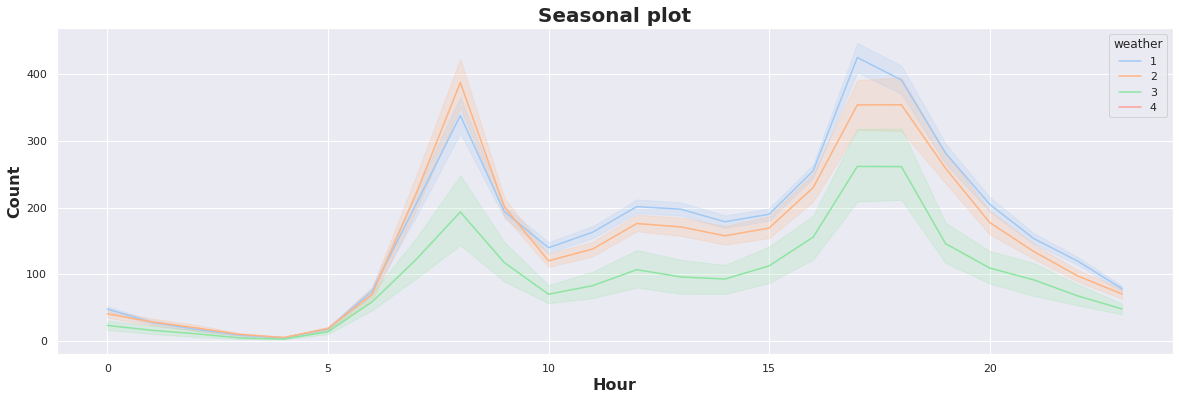

In [32]:
fig, ax = plt.subplots(figsize=(20, 6))

palette = sns.color_palette("pastel", 4)
sns.lineplot(df['hour'], df['registered'], hue=df['weather'], palette=palette)
ax.set_title('Seasonal plot', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Hour', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Count', fontsize = 16, fontdict=dict(weight='bold'))

Text(0, 0.5, 'Count')

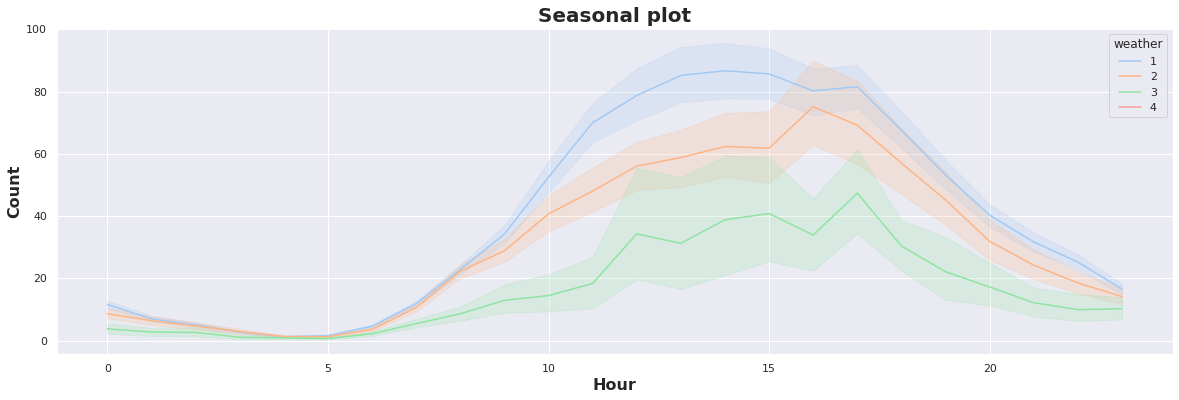

In [33]:
fig, ax = plt.subplots(figsize=(20, 6))

palette = sns.color_palette("pastel", 4)
sns.lineplot(df['hour'], df['casual'], hue=df['weather'], palette=palette)
ax.set_title('Seasonal plot', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Hour', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Count', fontsize = 16, fontdict=dict(weight='bold'))

Text(0, 0.5, 'Count')

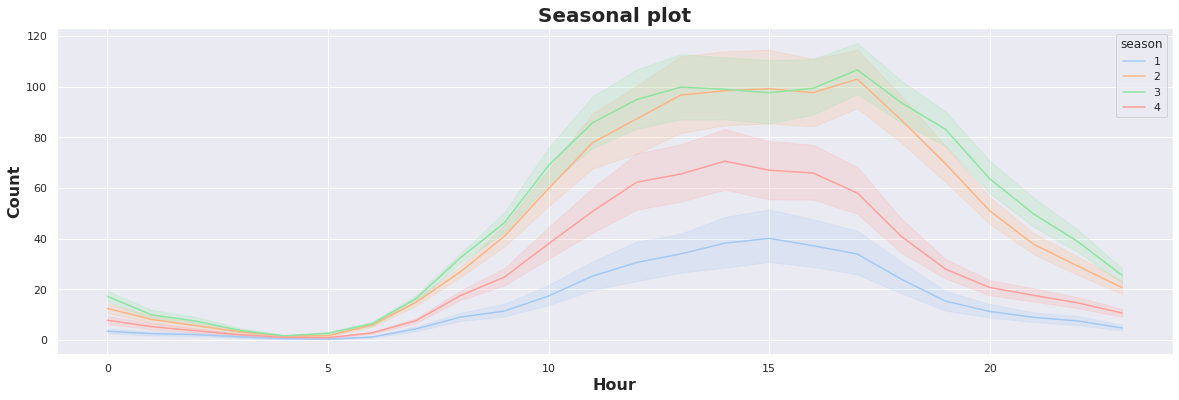

In [34]:
fig, ax = plt.subplots(figsize=(20, 6))

palette = sns.color_palette("pastel", 4)
sns.lineplot(df['hour'], df['casual'], hue=df['season'], palette=palette)
ax.set_title('Seasonal plot', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Hour', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Count', fontsize = 16, fontdict=dict(weight='bold'))

Text(0, 0.5, 'Count')

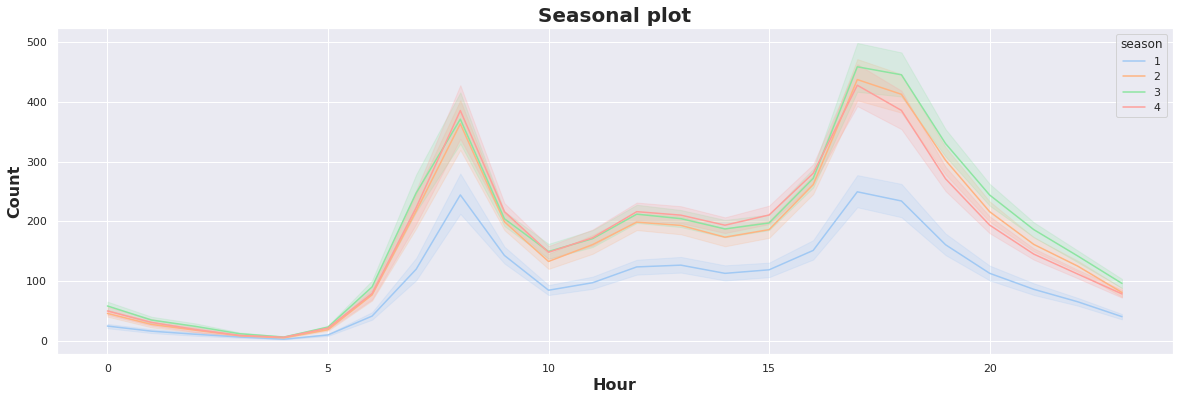

In [35]:
fig, ax = plt.subplots(figsize=(20, 6))

palette = sns.color_palette("pastel", 4)
sns.lineplot(df['hour'], df['registered'], hue=df['season'], palette=palette)
ax.set_title('Seasonal plot', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Hour', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Count', fontsize = 16, fontdict=dict(weight='bold'))

Text(0, 0.5, 'Count')

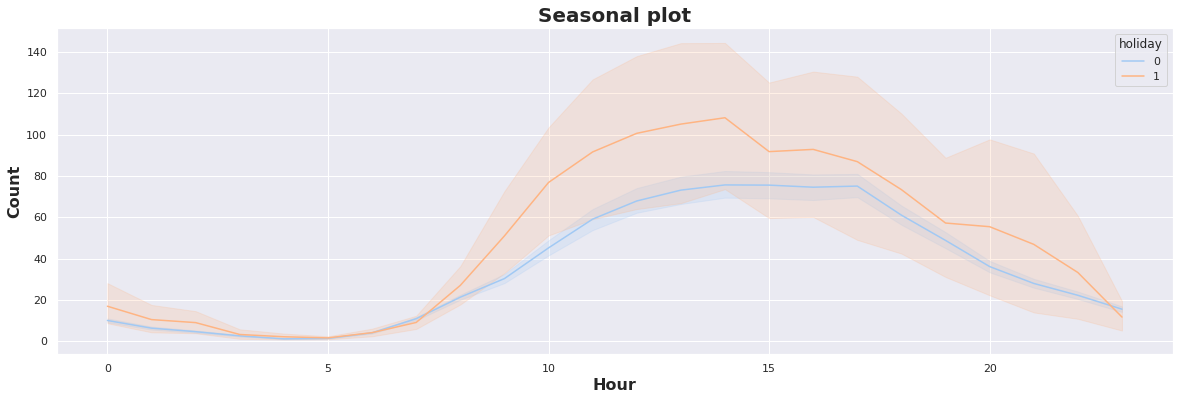

In [36]:
fig, ax = plt.subplots(figsize=(20, 6))

palette = sns.color_palette("pastel", 2)
sns.lineplot(df['hour'], df['casual'], hue=df['holiday'], palette=palette)
ax.set_title('Seasonal plot', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Hour', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Count', fontsize = 16, fontdict=dict(weight='bold'))

Text(0, 0.5, 'Count')

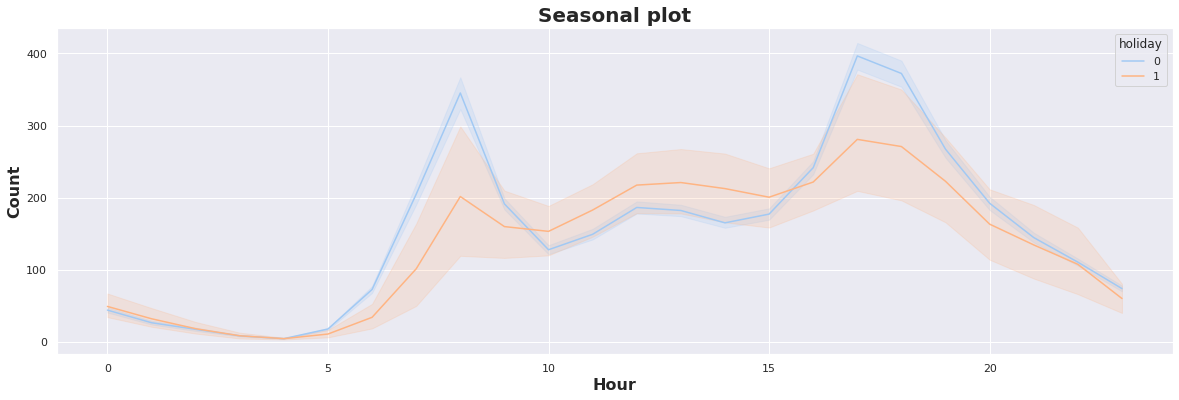

In [37]:
fig, ax = plt.subplots(figsize=(20, 6))

palette = sns.color_palette("pastel", 2)
sns.lineplot(df['hour'], df['registered'], hue=df['holiday'], palette=palette)
ax.set_title('Seasonal plot', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Hour', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Count', fontsize = 16, fontdict=dict(weight='bold'))

Text(0, 0.5, 'Count')

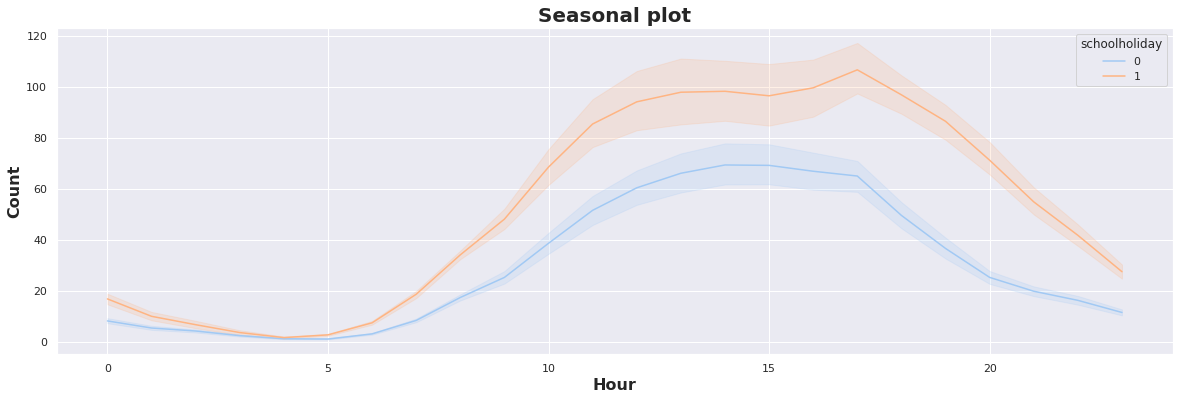

In [38]:
fig, ax = plt.subplots(figsize=(20, 6))

palette = sns.color_palette("pastel", 2)
sns.lineplot(df['hour'], df['casual'], hue=df['schoolholiday'], palette=palette)
ax.set_title('Seasonal plot', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Hour', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Count', fontsize = 16, fontdict=dict(weight='bold'))

Text(0, 0.5, 'Count')

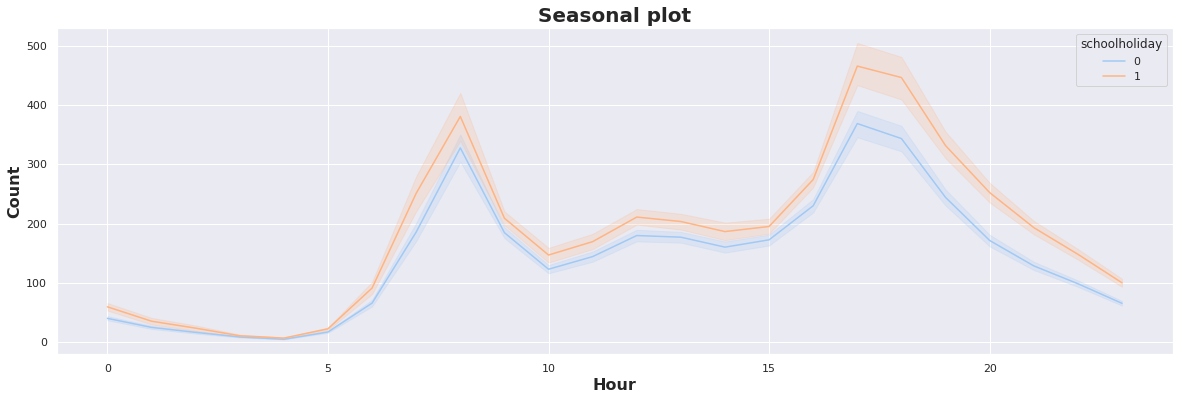

In [39]:
fig, ax = plt.subplots(figsize=(20, 6))

palette = sns.color_palette("pastel", 2)
sns.lineplot(df['hour'], df['registered'], hue=df['schoolholiday'], palette=palette)
ax.set_title('Seasonal plot', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Hour', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Count', fontsize = 16, fontdict=dict(weight='bold'))

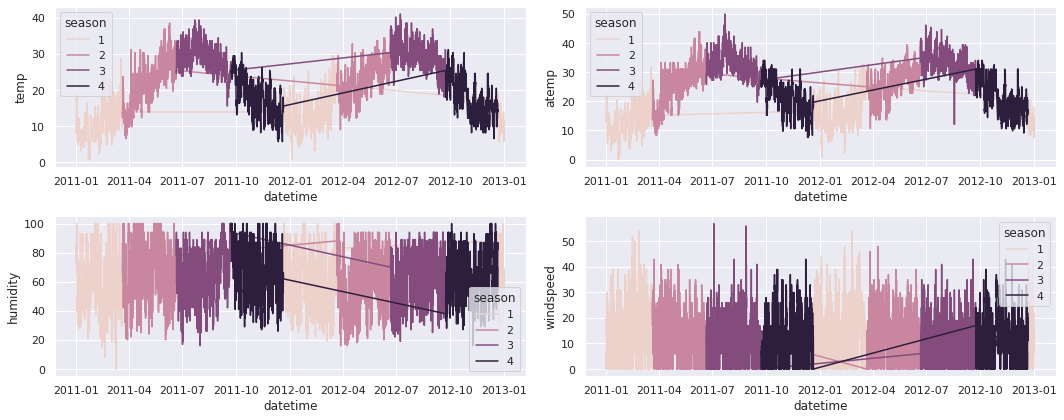

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(15,6))

sns.lineplot(x=df.index, y=df['temp'], hue=df.season, ax=axes[0,0])
sns.lineplot(x=df.index, y=df['atemp'], hue=df.season, ax=axes[0,1])
sns.lineplot(x=df.index, y=df['humidity'], hue=df.season, ax=axes[1,0])
sns.lineplot(x=df.index, y=df['windspeed'], hue=df.season, ax=axes[1,1])

fig.tight_layout()

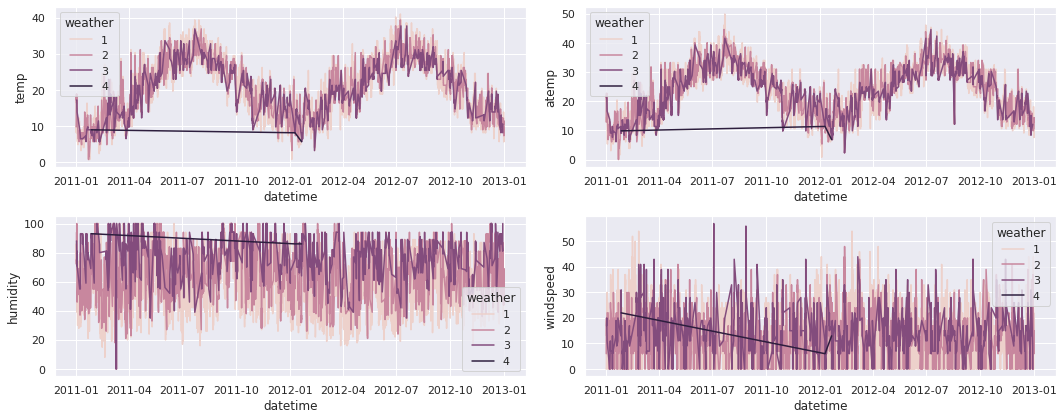

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(15,6))

sns.lineplot(x=df.index, y=df['temp'], hue=df.weather, ax=axes[0,0])
sns.lineplot(x=df.index, y=df['atemp'], hue=df.weather, ax=axes[0,1])
sns.lineplot(x=df.index, y=df['humidity'], hue=df.weather, ax=axes[1,0])
sns.lineplot(x=df.index, y=df['windspeed'], hue=df.weather, ax=axes[1,1])

fig.tight_layout()

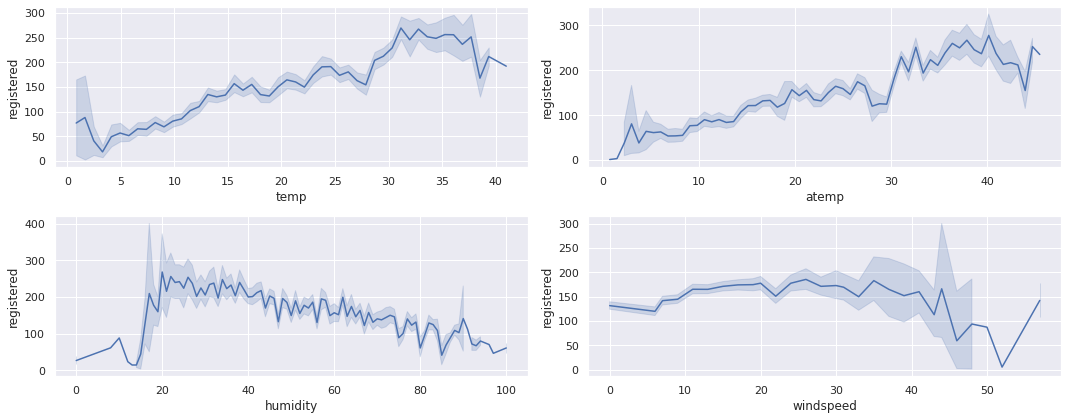

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(15,6))
sns.lineplot(y=df['registered'], x=df['temp'], ax=axes[0,0])
sns.lineplot(y=df['registered'], x=df['atemp'], ax=axes[0,1])
sns.lineplot(y=df['registered'], x=df['humidity'], ax=axes[1,0])
sns.lineplot(y=df['registered'], x=df['windspeed'], ax=axes[1,1])

fig.tight_layout()

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(15,6))
sns.lineplot(y=df['casual'], x=df['temp'], ax=axes[0,0])
sns.lineplot(y=df['casual'], x=df['atemp'], ax=axes[0,1])
sns.lineplot(y=df['casual'], x=df['humidity'], ax=axes[1,0])
sns.lineplot(y=df['casual'], x=df['windspeed'], ax=axes[1,1])

fig.tight_layout()

In [44]:
sns.lmplot(
    x='temp', y='registered', hue='season', col='season',
    data=df, col_wrap=7, height=4,)

In [45]:
sns.lmplot(
    x='temp', y='casual', hue='season', col='season',
    data=df, col_wrap=7, height=4,)

<AxesSubplot:>

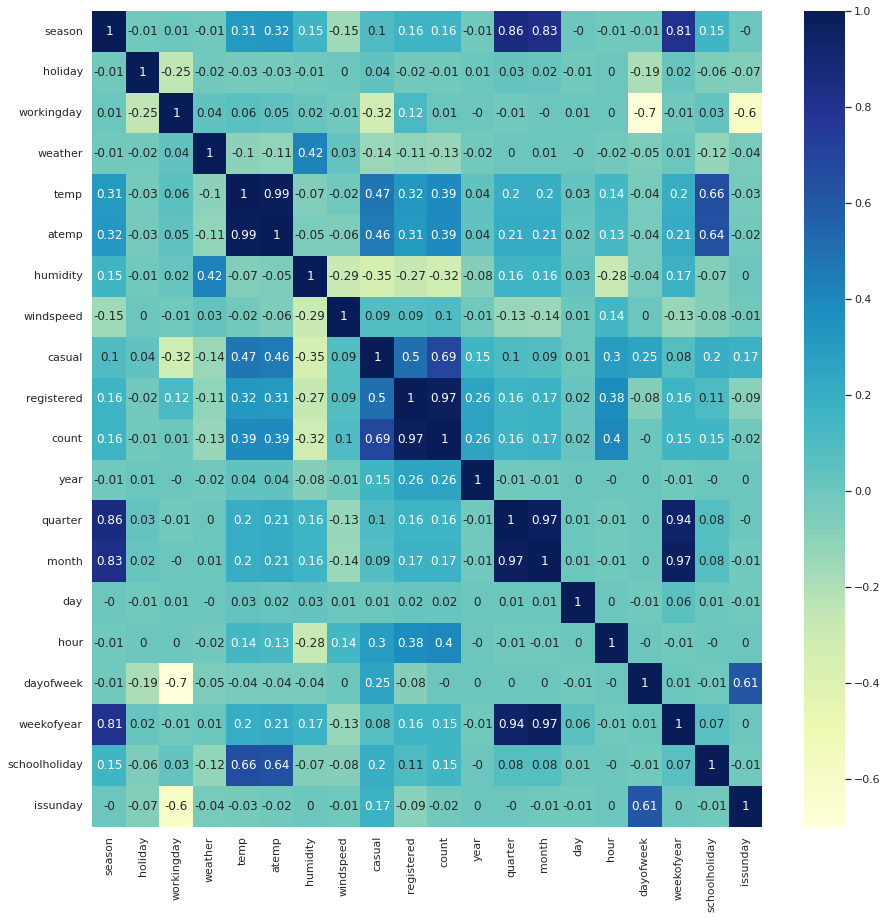

In [46]:
fig = plt.figure(figsize=(15,15))

corrMatrix = df.corr()
sns.heatmap(round(corrMatrix,2), annot=True, cmap="YlGnBu")

# The model

The plots showed completely different patterns between non-registered and registered customers, so I will create different features for each one.

As the weather feature for value 4 has few instances, I will aggregate them with the value 3. 

In [47]:
def ft_func(df):
    
    df['weather'] = df['weather'].apply(lambda x: x if x!=4 else 3)
    
    df.loc[df['count'].isnull(), 'test'] = df['count'].apply(lambda x: 1)
    df['test'] = df.test.apply(lambda x: x if x == 1 else 0)
     
    df['tottemp'] = df.groupby(by='day')['temp'].transform(lambda x: x.mean()) 
    df['tothumidity'] = df.groupby(by='day')['humidity'].transform(lambda x: x.mean()) 
    df['totwindspeed'] = df.groupby(by='day')['windspeed'].transform(lambda x: x.mean()) 
    
    return df

In [48]:
df = ft_func(df)

In [49]:
df.sample(10)

season  holiday  workingday  weather   temp   atemp  \
datetime                                                                   
2011-06-19 16:00:00       2        0           0        2  31.16  34.090   
2012-11-20 16:00:00       4        0           1        2  17.22  21.210   
2012-05-03 19:00:00       2        0           1        1  28.70  32.575   
2012-08-29 05:00:00       3        0           1        1  24.60  29.545   
2012-09-19 07:00:00       3        0           1        1  21.32  25.000   
2011-08-05 17:00:00       3        0           1        1  31.98  35.605   
2012-08-22 03:00:00       3        0           1        1  25.42  29.545   
2011-11-08 14:00:00       4        0           1        1  22.96  26.515   
2011-11-09 04:00:00       4        0           1        1  13.12  17.425   
2011-05-08 23:00:00       2        0           0        1  18.86  22.725   

                     humidity  windspeed  casual  registered  ...  day  hour  \
datetime                                                      ...              
2011-06-19 16:00:00        48     0.0000   121.0       257.0  ...   19    16   
2012-11-20 16:00:00        62     6.0032     NaN         NaN  ...   20    16   
2012-05-03 19:00:00        61    12.9980    55.0       467.0  ...    3    19   
2012-08-29 05:00:00        73    12.9980     NaN         NaN  ...   29     5   
2012-09-19 07:00:00        63    15.0013    16.0       529.0  ...   19     7   
2011-08-05 17:00:00        49    19.9995    84.0       466.0  ...    5    17   
2012-08-22 03:00:00        78     0.0000     NaN         NaN  ...   22     3   
2011-11-08 14:00:00        46     7.0015    32.0       129.0  ...    8    14   
2011-11-09 04:00:00        87     0.0000     0.0         4.0  ...    9     4   
2011-05-08 23:00:00        88     6.0032     9.0        41.0  ...    8    23   

                     dayofweek  weekofyear  schoolholiday  issunday  test  \
datetime                                                                    
2011-06-19 16:00:00          6          24              1         1   0.0   
2012-11-20 16:00:00          1          47              0         0   1.0   
2012-05-03 19:00:00          3          18              0         0   0.0   
2012-08-29 05:00:00          2          35              1         0   1.0   
2012-09-19 07:00:00          2          38              0         0   0.0   
2011-08-05 17:00:00          4          31              1         0   0.0   
2012-08-22 03:00:00          2          34              1         0   1.0   
2011-11-08 14:00:00          1          45              0         0   0.0   
2011-11-09 04:00:00          2          45              0         0   0.0   
2011-05-08 23:00:00          6          18              0         1   0.0   

                       tottemp  tothumidity  totwindspeed  
datetime                                                   
2011-06-19 16:00:00  20.674286    62.358885     12.467229  
2012-11-20 16:00:00  20.571429    64.163763     11.246055  
2012-05-03 19:00:00  19.913264    58.755672     12.345878  
2012-08-29 05:00:00  20.691749    59.859316     13.412750  
2012-09-19 07:00:00  20.674286    62.358885     12.467229  
2011-08-05 17:00:00  20.221913    61.784348     13.485597  
2012-08-22 03:00:00  20.267979    67.386643     11.475098  
2011-11-08 14:00:00  20.198571    62.756098     13.326335  
2011-11-09 04:00:00  19.818330    63.469565     12.374189  
2011-05-08 23:00:00  20.198571    62.756098     13.326335  

[10 rows x 24 columns]

#### Non-registered features

In [50]:
def cas_ft (df):
        
    X = df
    
    # Dummy features
    X = pd.get_dummies(X, columns=['year'], drop_first=True)
    X = pd.get_dummies(X, columns=['season'], drop_first=True)
    X = pd.get_dummies(X, columns=['weather'], drop_first=True)
    
    # DeterministicProcess
    fourierA = CalendarFourier(freq='A', order=3)
    fourierW = CalendarFourier(freq='W', order=2)
    fourierD = CalendarFourier(freq='D', order=5)

    dp = DeterministicProcess(index=X.index,
                              order=1,
                              seasonal=False,
                              constant=False,
                              additional_terms=[fourierA, fourierW, fourierD],
                              drop=True)
    dp_X = dp.in_sample()
    X = pd.concat([X, dp_X], axis=1)

    # Interaction terms
    for i in X.columns[X.columns.str.match(r'sin.*freq\=D.*|cos.*freq\=D.*')]:
        X[f'workingday{i}'] = X.workingday * X[i]
    
    for i in X.columns[X.columns.str.match(r'seas')]:
        X[f'temp{i}'] = X.temp * X[i]   
    
    return X

#### Registered features

In [51]:
def reg_ft (df):
        
    X = df
    
    # Dummy features
    X = pd.get_dummies(X, columns=['year'], drop_first=True)
    X = pd.get_dummies(X, columns=['season'], drop_first=True)
    X = pd.get_dummies(X, columns=['weather'], drop_first=True)
    
    # DeterministicProcess
    fourierA = CalendarFourier(freq='A', order=1)
    fourierW = CalendarFourier(freq='W', order=1)
    fourierD = CalendarFourier(freq='D', order=5)

    dp = DeterministicProcess(index=X.index,
                              order=1,
                              seasonal=False,
                              constant=False,
                              additional_terms=[fourierA, fourierW, fourierD],
                              drop=True)
    dp_X = dp.in_sample()
    X = pd.concat([X, dp_X], axis=1)
    
    # Interaction terms
    for i in X.columns[X.columns.str.match(r'sin.*freq\=D.*|cos.*freq\=D.*')]:
        X[f'workingday{i}'] = X.workingday * X[i]
    
    for i in X.columns[X.columns.str.match(r'seas')]:
        X[f'temp{i}'] = X.temp * X[i] 

    return X

I created a simple function to check: the performance of linear regression using cross validation; the summary of OLS for the significance of features; residual plots and other generic plots.

I applied a log transformation on the target in order to fix non-linarity e heteroscedasticity.

In [52]:
def model_func (orig_df, target, train):

    X = orig_df.copy()
    
    # Selecting features
    if target == 'casual':
        X = cas_ft(X)
        cols = X.columns[X.columns.str.match(r'trend|year|test|sin|cos|seas|weat|workingday|holiday|schoolholiday|temp|windspeed|tot')]
        y = np.log(X[target]+1)
    else:
        X = reg_ft(X)
        cols = X.columns[X.columns.str.match(r'trend|year|test|sin|cos|seas|weat|workingday|temp|hum|windspeed|tot')]
        y = np.log(X[target]+1)

    X = X.drop(columns=['casual', 'registered', 'count'])
    X = X.loc[:,cols]
    
    # Splitting training and test
    if train == 'train':        
        X_train, X_test, y_train, y_test = train_test_split(X[X['test']==0], y[~y.isnull()], random_state=10, test_size=0.3)  
    else:
        X_train = X[X['test']==0]
        X_test = X[X['test']==1]

        y_train = y[~y.isnull()]
        y_test = y[y.isnull()]
    
    # Linear Regression
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
                  
    lr_pred_train_y = lr_model.predict(X_train) 
    lr_pred_test_y = lr_model.predict(X_test)

    # XGB with residuals
    xgb_model = XGBRegressor(n_estimators=1000, seed=0, reg_alpha=0.40, learning_rate=0.02)
    xgb_res = y_train - lr_pred_train_y
    xgb_model.fit(X_train, xgb_res)
    pred_train_y = xgb_model.predict(X_train) + lr_pred_train_y
    pred_test_y = xgb_model.predict(X_test) + lr_pred_test_y
   
    pred_train_y = pd.Series(pred_train_y, index=y_train.index)
    pred_test_y = pd.Series(pred_test_y, index=y_test.index)
    
    
    if train == 'train':
        # Cross-validation on linear regression
        kf = KFold(10, shuffle=True, random_state=0).get_n_splits(X)
        rmse= (np.sqrt(-cross_val_score(LinearRegression(), X[X['test']==0], y[~y.isnull()], scoring="neg_mean_squared_error", cv=kf)))
        print('RMSLE_Cv: ', np.round(rmse, 4))
        print('RMSLE_Cv_Max: ', np.round(rmse.max(), 4), ', RMSLE_Cv_min: ', np.round(rmse.min(), 4))
        print('RMSLE_Cv_Mean: ', np.round(np.median(rmse), 4), ', RMSLE_Cv_Std: ', np.round(rmse.std(), 4), '\n')
        print(f'RMSLE_train tot: ', np.round(np.sqrt(mean_squared_error(y_train.clip(0.0), pred_train_y.clip(0.0))), 4), f'RMSLE_test tot: ', np.round(np.sqrt(mean_squared_error(y_test.clip(0.0), pred_test_y.clip(0.0))), 4), '\n')
        
        # OLS summary
        X = sm.add_constant(X, prepend=False)
        result = OLS(y_train, X_train).fit()
        pred = result.predict(X_train)
        print(result.summary(), '\n')
        
        # Plots
        fig, axes = plt.subplots(5, 2, figsize=(15,25))
        _ = plot_acf((y_train - pred_train_y), ax=axes[0,0])
    
        (y_train - pred_train_y).plot(ax=axes[0,1])

        _ = plot_acf((y_test - pred_test_y), ax=axes[1,0])
        
        (y_test - pred_test_y).plot(ax=axes[1,1])
    
        sns.residplot(ax=axes[2,0], x=pred_train_y, y=zscore(y_train - pred_train_y), data=X, lowess=True, scatter_kws={'alpha': 0.5}, 
                     line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
        sns.residplot(ax=axes[2,1], x=pred_test_y, y=zscore(y_test - pred_test_y), data=X, lowess=True, scatter_kws={'alpha': 0.5}, 
                     line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

        sns.lineplot(df['month'], np.log1p(df[target]), ax=axes[3,0], hue=df.year, color='orange')
        sns.lineplot(df['month'], pred_train_y, hue=df.year, ax=axes[3,0])

        sns.lineplot(df['dayofweek'], np.log1p(df[target]), ax=axes[3,1], hue=df.year, color='orange')
        sns.lineplot(df['dayofweek'], pred_train_y, hue=df.year, ax=axes[3,1])

        sns.lineplot(df['hour'], np.log1p(df[target]), ax=axes[4,0], hue=df.year, color='orange')
        sns.lineplot(df['hour'], pred_train_y, hue=df.year, ax=axes[4,0])

        sns.lineplot(df['atemp'], np.log1p(df[target]), ax=axes[4,1], hue=df.year, color='orange')
        sns.lineplot(df['atemp'], pred_train_y, hue=df.year, ax=axes[4,1])
        
        fig.tight_layout()
        
        return pred_test_y, X, y
    else:        
        return pred_test_y
        

In [53]:
#cas_y, X, casual = model_func(df, 'casual', 'train')

In [54]:
#reg_y, X, reg = model_func(df, 'registered', 'train')

In [55]:
#fin = (np.exp(cas_y)-1) + (np.exp(reg_y)-1)

In [56]:
#fin = fin.apply(lambda x: 0 if x<0 else x)

In [57]:
#df['count'].plot()
#fin.plot()

In [58]:
cas_y = model_func(df, 'casual', 'test')

In [59]:
reg_y = model_func(df, 'registered', 'test')

In [60]:
fin = (np.exp(cas_y)-1) + (np.exp(reg_y)-1)

# Last Check

Text(0, 0.5, 'Count')

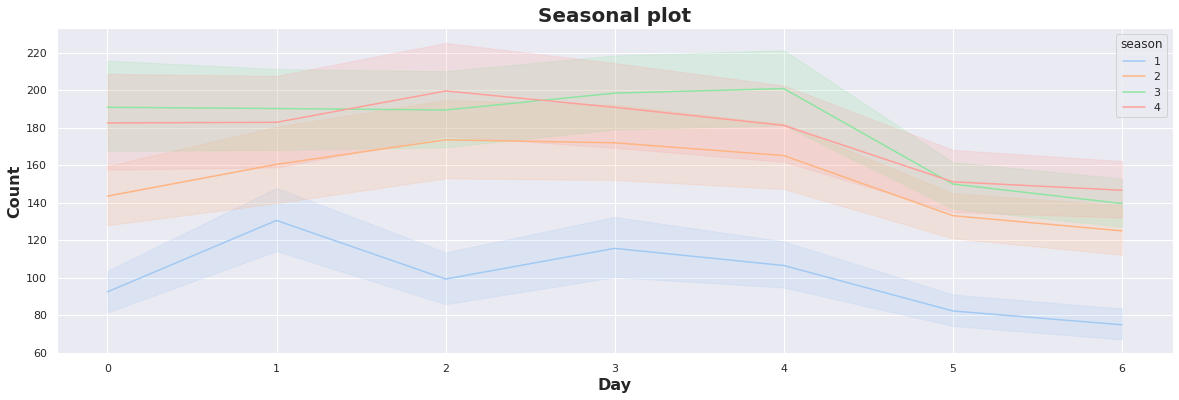

In [61]:
fig, ax = plt.subplots(figsize=(20, 6))

palette = sns.color_palette("pastel", 4)
sns.lineplot(df['dayofweek'], (np.exp(reg_y)-1), hue=df['season'], palette=palette)
ax.set_title('Seasonal plot', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Day', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Count', fontsize = 16, fontdict=dict(weight='bold'))

Text(0, 0.5, 'Count')

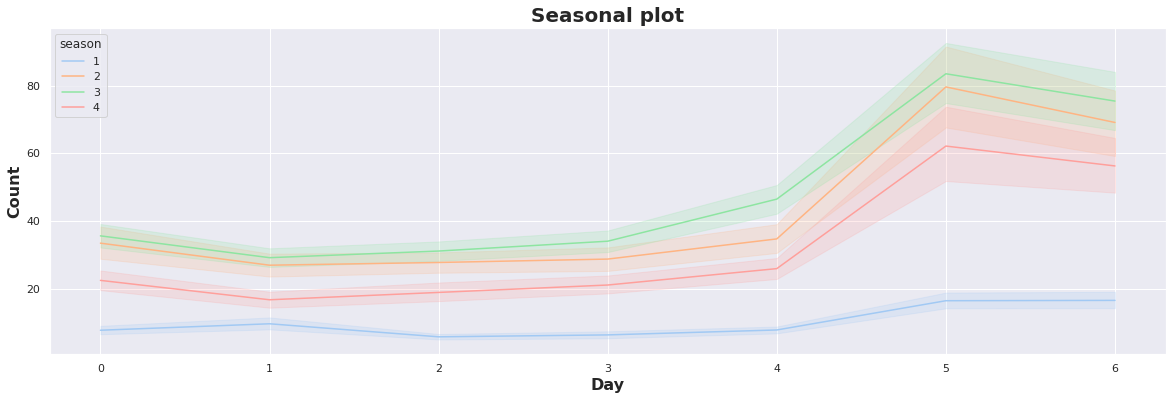

In [62]:
fig, ax = plt.subplots(figsize=(20, 6))

palette = sns.color_palette("pastel", 4)
sns.lineplot(df['dayofweek'], (np.exp(cas_y)-1), hue=df['season'], palette=palette)
ax.set_title('Seasonal plot', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Day', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Count', fontsize = 16, fontdict=dict(weight='bold'))

In [63]:
fig, ax = plt.subplots(figsize=(20, 6))

palette = sns.color_palette("pastel", 7)
sns.lineplot(df['hour'], (np.exp(reg_y)-1), hue=df['dayofweek'], palette=palette)
ax.set_title('Seasonal plot', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Hour', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Count', fontsize = 16, fontdict=dict(weight='bold'))
plt.axvline(x=8, color='black', linestyle='--', linewidth=1, alpha=0.5)
plt.axvline(x=17, color='black', linestyle='--', linewidth=1, alpha=0.5)
plt.axvline(x=18, color='black', linestyle='--', linewidth=1, alpha=0.5)

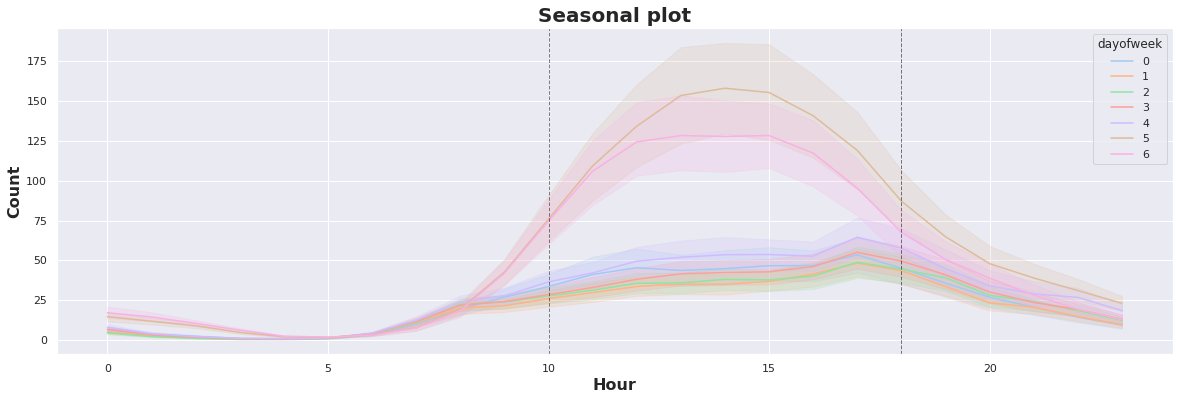

In [64]:
fig, ax = plt.subplots(figsize=(20, 6))

palette = sns.color_palette("pastel", 7)
sns.lineplot(df['hour'], (np.exp(cas_y)-1), hue=df['dayofweek'], palette=palette)
ax.set_title('Seasonal plot', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Hour', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Count', fontsize = 16, fontdict=dict(weight='bold'))
plt.axvline(x=10, color='black', linestyle='--', linewidth=1, alpha=0.5)
plt.axvline(x=18, color='black', linestyle='--', linewidth=1, alpha=0.5)

<AxesSubplot:xlabel='datetime'>

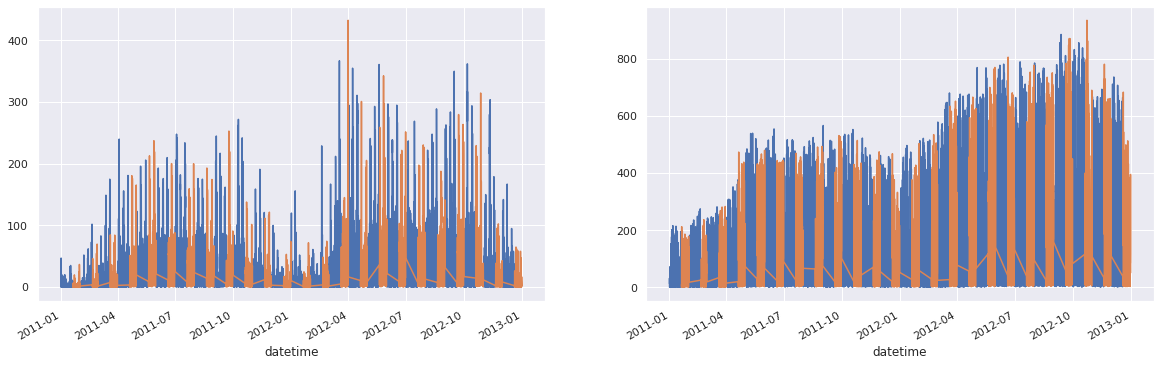

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(20,6))

df['casual'].plot(ax=axes[0])
(np.exp(cas_y)-1).plot(ax=axes[0])
df['registered'].plot(ax=axes[1])
(np.exp(reg_y)-1).plot(ax=axes[1])

<AxesSubplot:xlabel='datetime'>

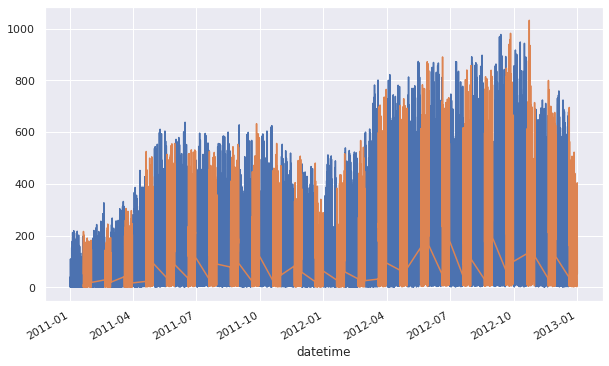

In [66]:
fig, axes = plt.subplots(1, 1, figsize=(10,6))

df['count'].plot()
fin.plot()

# Submission

In [67]:
fin = pd.DataFrame(fin, index=test.set_index('datetime').index, columns=['count'])

In [68]:
fin['count'] = fin['count'].apply(lambda x: 0 if x<0 else x)

In [69]:
fin.sample(10)

count
datetime                       
2012-07-24 23:00:00  123.986602
2011-08-24 21:00:00  186.697267
2011-07-29 20:00:00  250.290875
2012-10-28 13:00:00  498.894787
2011-11-25 01:00:00   17.457952
2011-08-29 15:00:00  184.887748
2012-12-24 09:00:00  226.393208
2011-07-27 17:00:00  512.847699
2011-03-28 01:00:00    4.384969
2011-12-31 08:00:00   47.907541

In [70]:
fin.to_csv('submission.csv')